## Prototype for Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of a new prototype method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate some survival data

In [2]:
# Generate data from the Log-normal model (Mvt + Heterosc.) of Candes et al. (Table 1)
source("utils_data.R")

# Numbers of features (>= 10)
num_features <- 10

# Sample sizes
num_samples_train <- 2000
num_samples_cal <- 1000
num_samples_test <- 1000

# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generate_survival_data(num_samples_train, num_features)
data.cal.oracle <- generate_survival_data(num_samples_cal, num_features)
data.test.oracle <- generate_survival_data(num_samples_test, num_features)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

Let's take a look at the data

In [3]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(event), 
              `Mean observed time`=mean(observed_time),
              `Mean observed event time`=mean(observed_time[event]),
              `Mean censoring time` = mean(censoring_time))

Observations,Events,Mean observed time,Mean observed event time,Mean censoring time
<int>,<int>,<dbl>,<dbl>,<dbl>
2000,583,3.633453,6.061866,5.056377


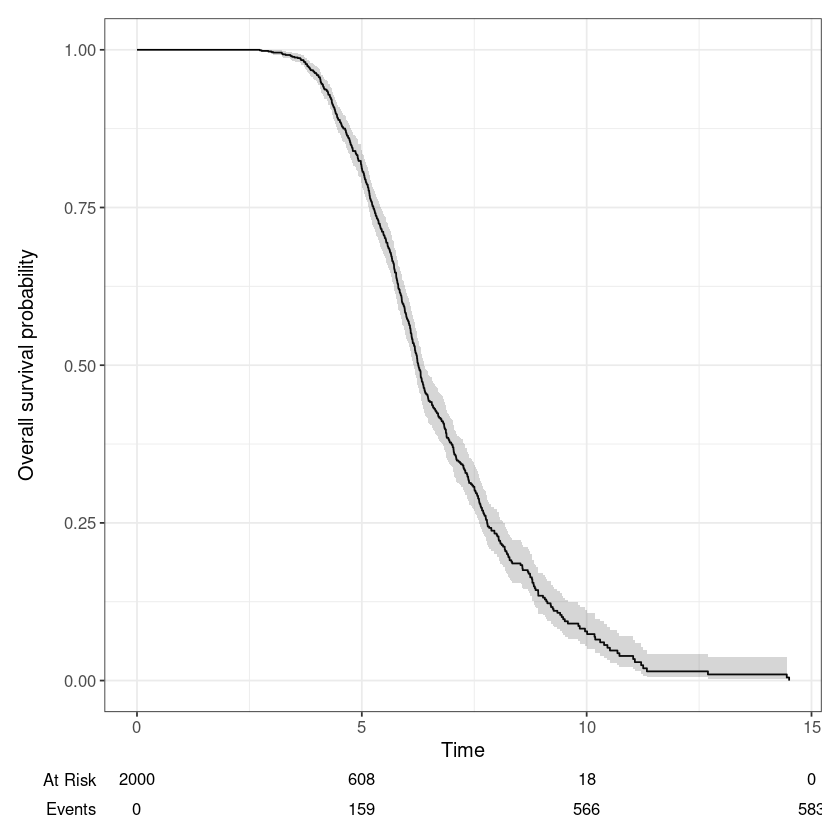

In [4]:
# Kaplan-Meier plot
survfit2(Surv(observed_time, event) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Fit survival model (random forest)

Let's fit a survival model using the training data under type-I censoring. 

In [5]:
X.train <- as.matrix(select(data.train, starts_with("X")))
Y.train <- data.train$observed_time
D.train <- data.train$event
fit <- grf::survival_forest(X.train, Y.train, D.train)
fit

GRF forest object of type survival_forest 
Number of trees: 1000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.665 0.061 0.061 0.021 0.057 0.024 0.028 0.033 0.030 0.020 

## Visualize the model's predictions

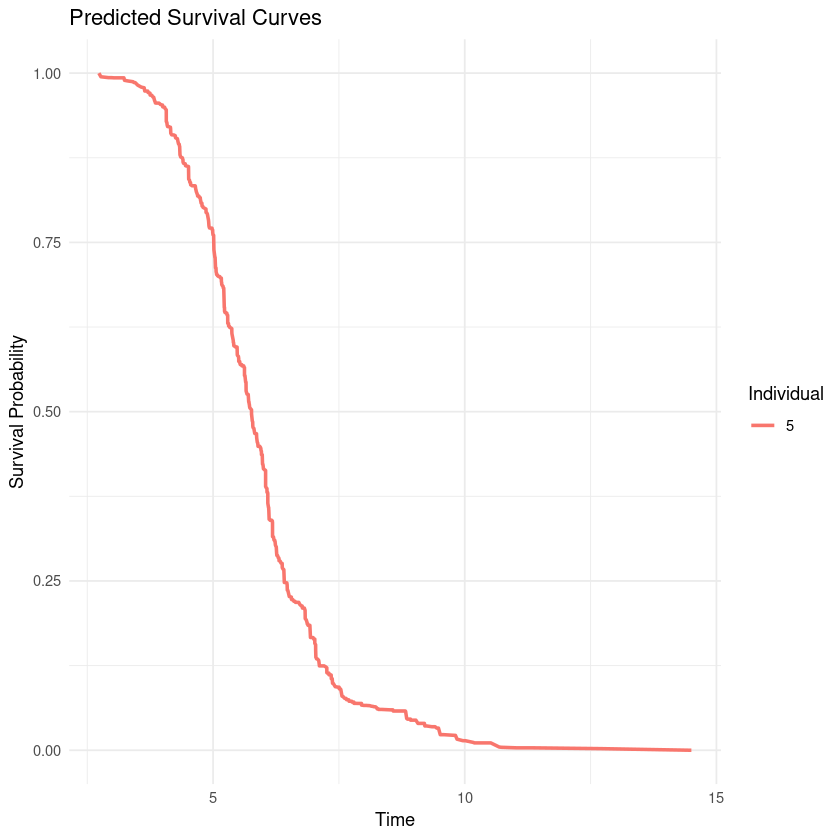

In [6]:
source("utils_plotting.R")
X.cal <- as.matrix(select(data.cal, starts_with("X")))
plot_survival_curves(fit, newX=X.cal, individuals=c(5))

## Predict survival time quantiles

In [7]:
source("utils_survival.R")

percentiles <- c(0.7,0.8,0.9,0.95)
predicted_quantiles <- compute_survival_quantiles(fit, newX=X.cal, 
                                                  percentiles=percentiles) 
                        
predicted_quantiles |> head()

,Q70%,Q80%,Q90%,Q95%
,<dbl>,<dbl>,<dbl>,<dbl>
Individual_1,6.656470,6.083199,5.284906,4.727271
Individual_2,6.405738,5.927030,5.443317,4.797517
Individual_3,6.405738,5.810809,5.324930,4.977450
Individual_4,5.928940,5.509917,4.643188,4.413336
Individual_5,5.105004,4.858350,4.301399,4.036175
Individual_6,5.211886,4.777653,4.363649,3.865265


## Conformalized quantile regression (CQR)

In [8]:
alpha = 0.1

X.cal <- as.matrix(select(data.cal, starts_with("X")))
Y.cal <- data.cal$observed_time
X.test <- as.matrix(select(data.test, starts_with("X")))

pred.cqr <- predict_CQR(X.test, fit, X.cal, Y.cal, alpha)

evaluate_bounds(data.test.oracle$observed_time, 
                pred.cqr$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.901,0.5254773,1


## CQR with censoring time imputation

Using our (oracle) knowledge of the censoring distribution, let's impute the missing censoring times.

In [9]:
source("utils_data.R")

# Impute the missing censoring times
idx.event <- which(data.cal$event==TRUE)
C.cal.imputed <- impute_censoring_times(X.cal[idx.event], Y.cal[idx.event])

# Add the censoring times to the data frame
data.cal$censoring_time_imputed <- data.cal$observed_time
data.cal$censoring_time_imputed[idx.event] <- C.cal.imputed
data.cal <- data.cal |> select(observed_time, event, censoring_time_imputed,
                               everything())

Let's look at how the imputed censoring times compare to the observed times.

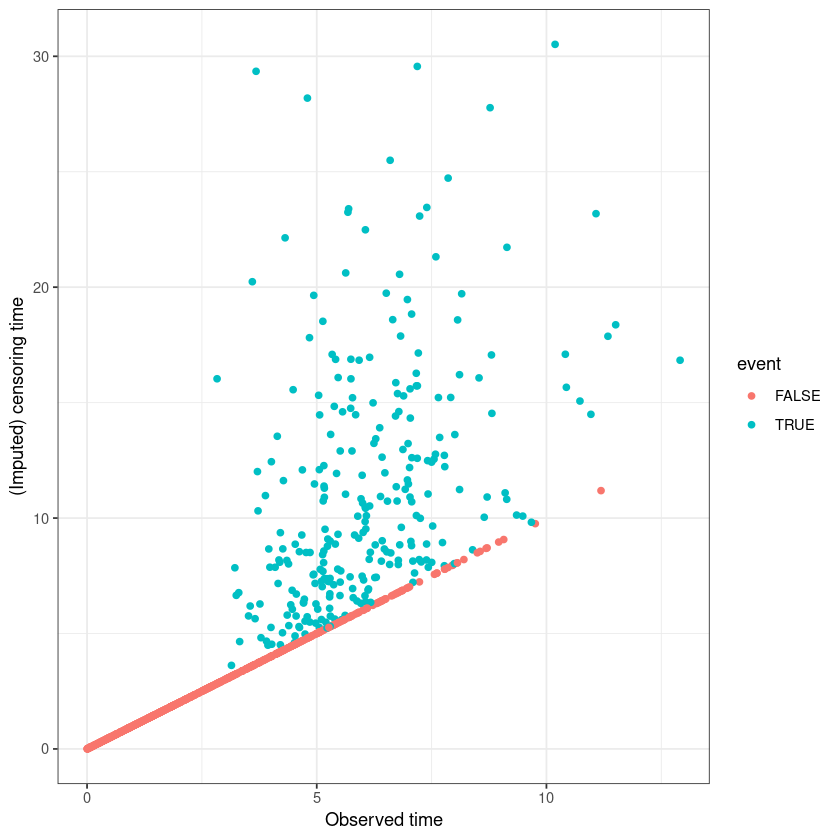

In [10]:
data.cal |>
    ggplot(aes(x=observed_time, y=censoring_time_imputed, color=event)) +
    geom_point() +
    theme_bw() +
    labs(x="Observed time", y="(Imputed) censoring time")

We now effectively have a data set with type-I censoring, so we can apply Candes' method.

In [11]:
source("utils_survival.R")

C.cal <- data.cal$censoring_time_imputed

pred.proto <- predict_Candes(X.test, fit, X.cal, Y.cal, C.cal, alpha, c0=5)

evaluate_bounds(data.test.oracle$observed_time,
                pred.proto$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.431,4.20588,0.981


## Repeated experiments

In [12]:
# Experimental settings
num_samples_train <- 2000
num_samples_cal <- 1000
num_samples_test <- 1000
num_features <- 10
alpha = 0.1
c0 = 5

run_experiment <- function(seed) {
    set.seed(seed)
    # Generate training, calibration, and test data
    # (including true event and censoring times)
    data.train.oracle <- generate_survival_data(num_samples_train, num_features)
    data.cal.oracle <- generate_survival_data(num_samples_cal, num_features)
    data.test.oracle <- generate_survival_data(num_samples_test, num_features)

    # Remove true event and censoring times from the data
    data.train <- data.train.oracle |> select(-event_time, -censoring_time)
    data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
    data.test <- data.test.oracle |> select(-event_time, -censoring_time)

    # Fit survival model on training data
    X.train <- as.matrix(select(data.train, starts_with("X")))
    Y.train <- data.train$observed_time
    D.train <- data.train$event
    fit <- grf::survival_forest(X.train, Y.train, D.train)
    
    # Apply CQR to compute lower prediction intervals  
    X.cal <- as.matrix(select(data.cal, starts_with("X")))
    Y.cal <- data.cal$observed_time
    X.test <- as.matrix(select(data.test, starts_with("X")))
    pred <- predict_CQR(X.test, fit, X.cal, Y.cal, alpha)
    lower_uncalibrated <- pred$uncalibrated
    lower_cqr <- pred$calibrated
    
    # Impute the missing censoring times
    idx.event <- which(data.cal$event==TRUE)
    C.cal.imputed <- impute_censoring_times(X.cal[idx.event], Y.cal[idx.event])

    # Add the censoring times to the data frame
    data.cal$censoring_time_imputed <- data.cal$observed_time
    data.cal$censoring_time_imputed[idx.event] <- C.cal.imputed
    data.cal <- data.cal |> select(observed_time, event, censoring_time_imputed,
                                   everything())
    C.cal <- data.cal$censoring_time_imputed
    
    # Apply prototype to compute lower prediction intervals  
    X.test <- as.matrix(select(data.test, starts_with("X")))
    pred.proto <- predict_Candes(X.test, fit, X.cal, Y.cal, C.cal, alpha, c0=c0)
    lower_proto <- pred.proto$calibrated
       
    # Evaluate results
    observed_time = data.test.oracle$observed_time
    true_event_time = data.test.oracle$event_time
    res.uncalibrated <- evaluate_bounds(observed_time, 
                                        lower_uncalibrated,
                                        event_time=true_event_time) |>
        mutate(Method="Uncalibrated")
    res.cqr <- evaluate_bounds(observed_time, 
                               lower_cqr,
                               event_time=true_event_time) |>
        mutate(Method="CQR")
    res.proto <- evaluate_bounds(observed_time, 
                                 lower_proto,
                                 event_time=true_event_time) |>
        mutate(Method="Prototype")
    
    
    res <- rbind(res.uncalibrated, res.cqr, res.proto) |>
    mutate(Seed=seed) |> select(Seed, everything())
    return(res)
}

In [13]:
# Run one experiment
run_experiment(1)

Seed,Coverage (observed time),Mean lower bound,Coverage (event time),Method
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.353,4.8238183,0.924,Uncalibrated
1,0.885,0.5981501,1.000,CQR
1,0.448,3.9766283,0.987,Prototype


The prototype is still a bit conservative, but it works much better than naive CQR.

In [14]:
# Define the seeds for the experiments
seeds <- 1:10

# Initialize a list to store results
results <- list()

# Total number of seeds
n <- length(seeds)

# Loop over the seeds
for (i in seq_along(seeds)) {
  seed <- seeds[i]
  # Run the experiment and store the result
  results[[i]] <- run_experiment(seed)
}

# Combine all tibbles into a single tibble
combined_results <- bind_rows(results)

Plot results from experiments

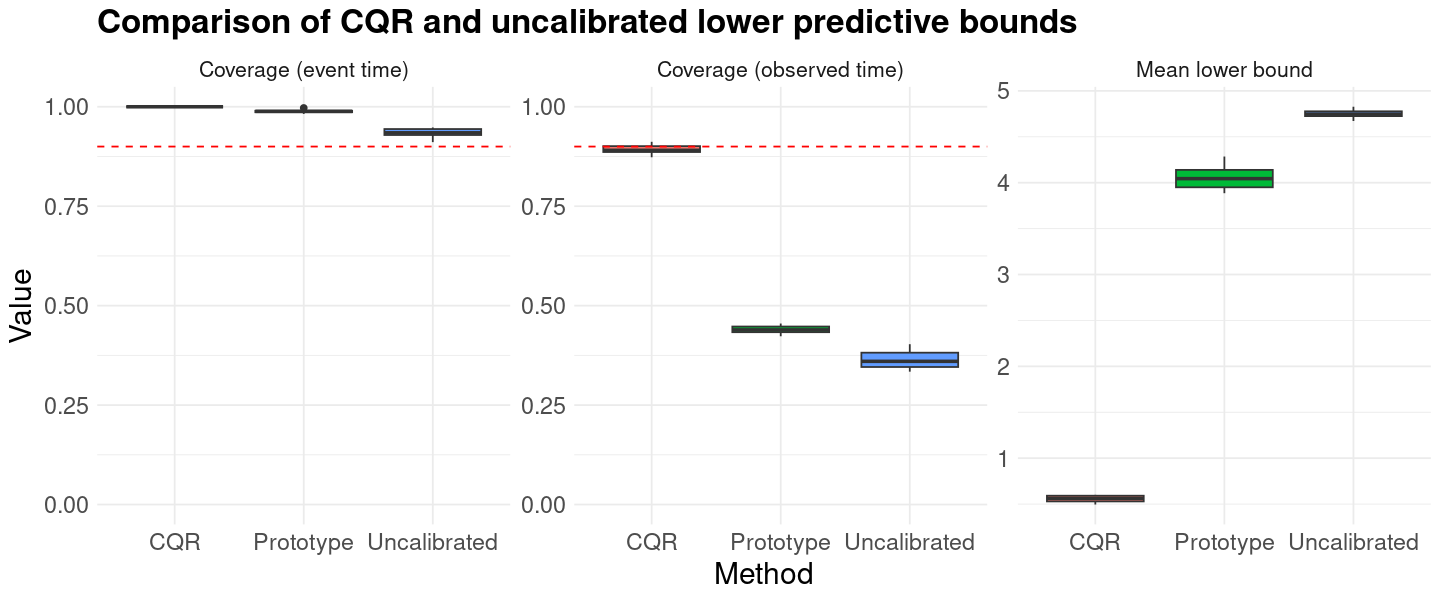

In [15]:
df <- combined_results

# Reshape the data for ggplot2
df_long <- df %>%
  pivot_longer(cols = c(`Coverage (observed time)`,
                        `Mean lower bound`, 
                        `Coverage (event time)`),
               names_to = "Metric",
               values_to = "Value")

# Set the plot size for Jupyter
options(repr.plot.width = 12, repr.plot.height = 5)
        
# Create the plot
ggplot(df_long, aes(x = Method, y = Value, fill = Method)) +
  geom_boxplot() +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 0.9), 
             linetype = "dashed", color = "red") +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 1), 
             linetype = "dashed", alpha=0) +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 0), 
             linetype = "dashed", alpha=0) +
  facet_wrap(~Metric, scales = "free_y") +
  theme_minimal() +
  labs(title = "Comparison of CQR and uncalibrated lower predictive bounds",
       x = "Method",
       y = "Value") +
  theme(
    text = element_text(size = 16),             # Increase all text elements
    axis.title = element_text(size = 18),       # Increase axis titles
    axis.text = element_text(size = 14),        # Increase axis text
    legend.position = "none",                   # Remove legend
    plot.title = element_text(size = 20, face = "bold") # Increase and bold plot title
  )

The prototype is still a bit conservative, but it works much better than naive CQR.